## SHAP Deep Explainer



### Идея метода

Алгоритм [DeepLIFT](https://arxiv.org/abs/1704.02685) — развитие идеи **Vanilla Gradient**, чем-то похожее на Integrated Gradients. Основная идея **DeepLIFT** заключается в том, что он оценивает важность признака с точки зрения **отличий от некоторого «референса»**, где референс выбирается в соответствии с решаемой проблемой. Референс для входных данных представляет собой некий нейтральный объект, у которого отсутствует специфическое свойство, например, таким свойством может быть присутствие/отсутствие того или иного объекта на изображении. Помимо референса для входных данных, определяется референс для каждого нейрона (активация соответствующего нейрона, рассчитанная для референсного объекта), аналогично референсом выхода сети будет вычисленный выход для референсного объекта.

DeepLIFT объясняет разницу между выходом сети для целевого объекта и выходом сети для референсного объекта на основании разницы между этими объектами. Пусть $t$ представляет собой выход некоторого нейрона/сети, а $x_1,x_2,...,x_n$ — нейроны одного из предшествующих слоев или множества слоев, необходимые для расчета $t$. Пусть $t_0$ — референсная активация для $t$. Тогда мы можем определить разницу выхода нейрона/сети для целевого объекта с выходом для референсного объекта как $\Delta t=t-t_0$. Тогда мы можем разложить ее на вклады $C_{\Delta x_i \Delta t}$  разниц между активациями нейронов в предыдущих слоях для целевого объекта и референса ($\Delta x_i$):

$$\large \sum_{i=1}^nC_{\Delta x_i \Delta t}=\Delta t$$

Как именно DeepLIFT вычисляет эти вклады останется за рамками рассмотрения этой лекции.

Использование такого подхода позволяет DeepLIFT решать проблему насыщения, приведенную выше, а также другую проблему, при которой градиент может совершать спонтанные скачки. Для иллюстрации этого примера рассмотрим функцию ReLU со сдвигом на $-10$: $y=max(0,x-10)$. Для этой функции градиент и вход, умноженный на градиент (этот подход также может быть использован для объяснения предсказаний нейронных сетей), имеют разрыв в точке $x=10$. В отличие от этого подход, основанный на разнице с референсом, дает непрерывную величину оценки вклада признака.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L14/deeplift_relu.png" width="800">

<center><p><em>Source: <a href="https://arxiv.org/pdf/1704.02685.pdf">Learning Important Features Through Propagating Activation Differences</a></p> </em></center>

###Пример изображения (ResNet18)

В качестве референса конкретно в SHAP DeepExlainer, построенном на основе DeepLIFT, используется не один объект, а усреднение набора произвольных изображений из датасета ImageNet (`shap.datasets.imagenet50`).

Попробуем воспользоваться этим на практике:

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L14/cat_and_dog1.jpg' -O cat_and_dog1.jpg
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L14/cat_and_dog2.png' -O cat_and_dog2.png
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagenet_class_index.json' -O imagenet_class_index.json

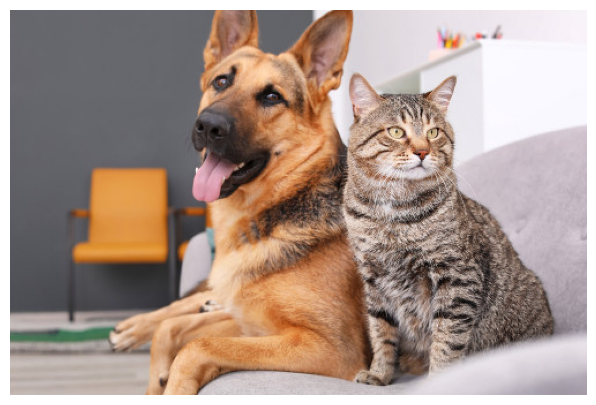

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image


def get_image(path):
    with open(os.path.abspath(path), "rb") as f:
        with Image.open(f) as img:
            return img.convert("RGB")


img = get_image("cat_and_dog1.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
from torchvision import transforms

# resize & normalize


def get_input_transform():
    transform = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
            ),
        ]
    )
    return transform


# for get croped img from input tensor


def get_reverse_transform():
    transform = transforms.Compose(
        [
            transforms.Normalize(
                mean=(0.0, 0.0, 0.0), std=(1 / 0.229, 1 / 0.224, 1 / 0.225)
            ),
            transforms.Normalize(
                mean=(-0.485, -0.456, -0.406),
                std=(1.0, 1.0, 1.0),
            ),
            transforms.Lambda(lambda x: torch.permute(x, (0, 2, 3, 1))),
            transforms.Lambda(lambda x: x.detach().numpy()),
        ]
    )
    return transform


def get_input_tensors(img):
    transform = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)


def get_crop_img(img_tensor):
    transform = get_reverse_transform()
    return transform(img_tensor)[0]

In [ ]:
import torch
import json
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")


idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath("/content/imagenet_class_index.json"), "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    lable2idx = {class_idx[str(k)][1]: k for k in range(len(class_idx))}

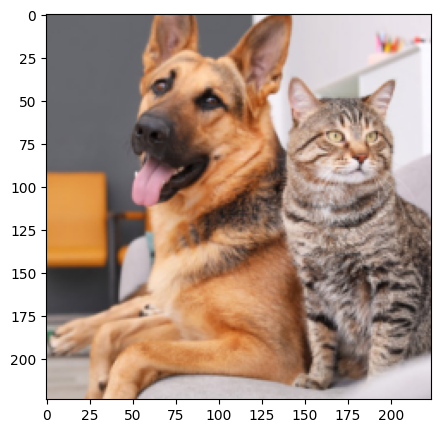

((0.403076, 235, 'German_shepherd'),
 (0.095318, 281, 'tabby'),
 (0.06907906, 282, 'tiger_cat'),
 (0.026926257, 285, 'Egyptian_cat'),
 (0.022851909, 811, 'space_heater'))

In [ ]:
import torch.nn.functional as F

img_t = get_input_tensors(img)
model.eval()
model.cpu()
logits = model(img_t)

probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
fig = plt.figure(figsize=(5, 5))
plt.imshow(get_crop_img(img_t))
plt.show()
tuple(
    (p, c, idx2label[c])
    for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy())
)

In [ ]:
!pip install -q shap

Посмотрим на изображения, выбранные в качестве референса

Data shape: (50, 224, 224, 3) , type:  <class 'numpy.ndarray'>


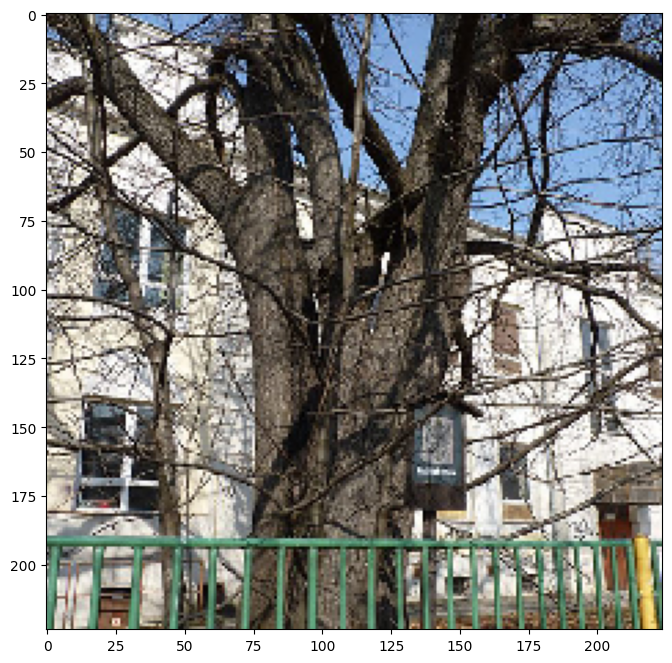

In [ ]:
import shap


imagenet_50, broken_targets = shap.datasets.imagenet50()

print("Data shape:", imagenet_50.shape, ", type: ", type(imagenet_50))
# Show first image
fig = plt.figure(figsize=(8, 8))
plt.imshow(imagenet_50[0].astype("int"))
plt.show()

Можно взглянуть и на остальные картинки:

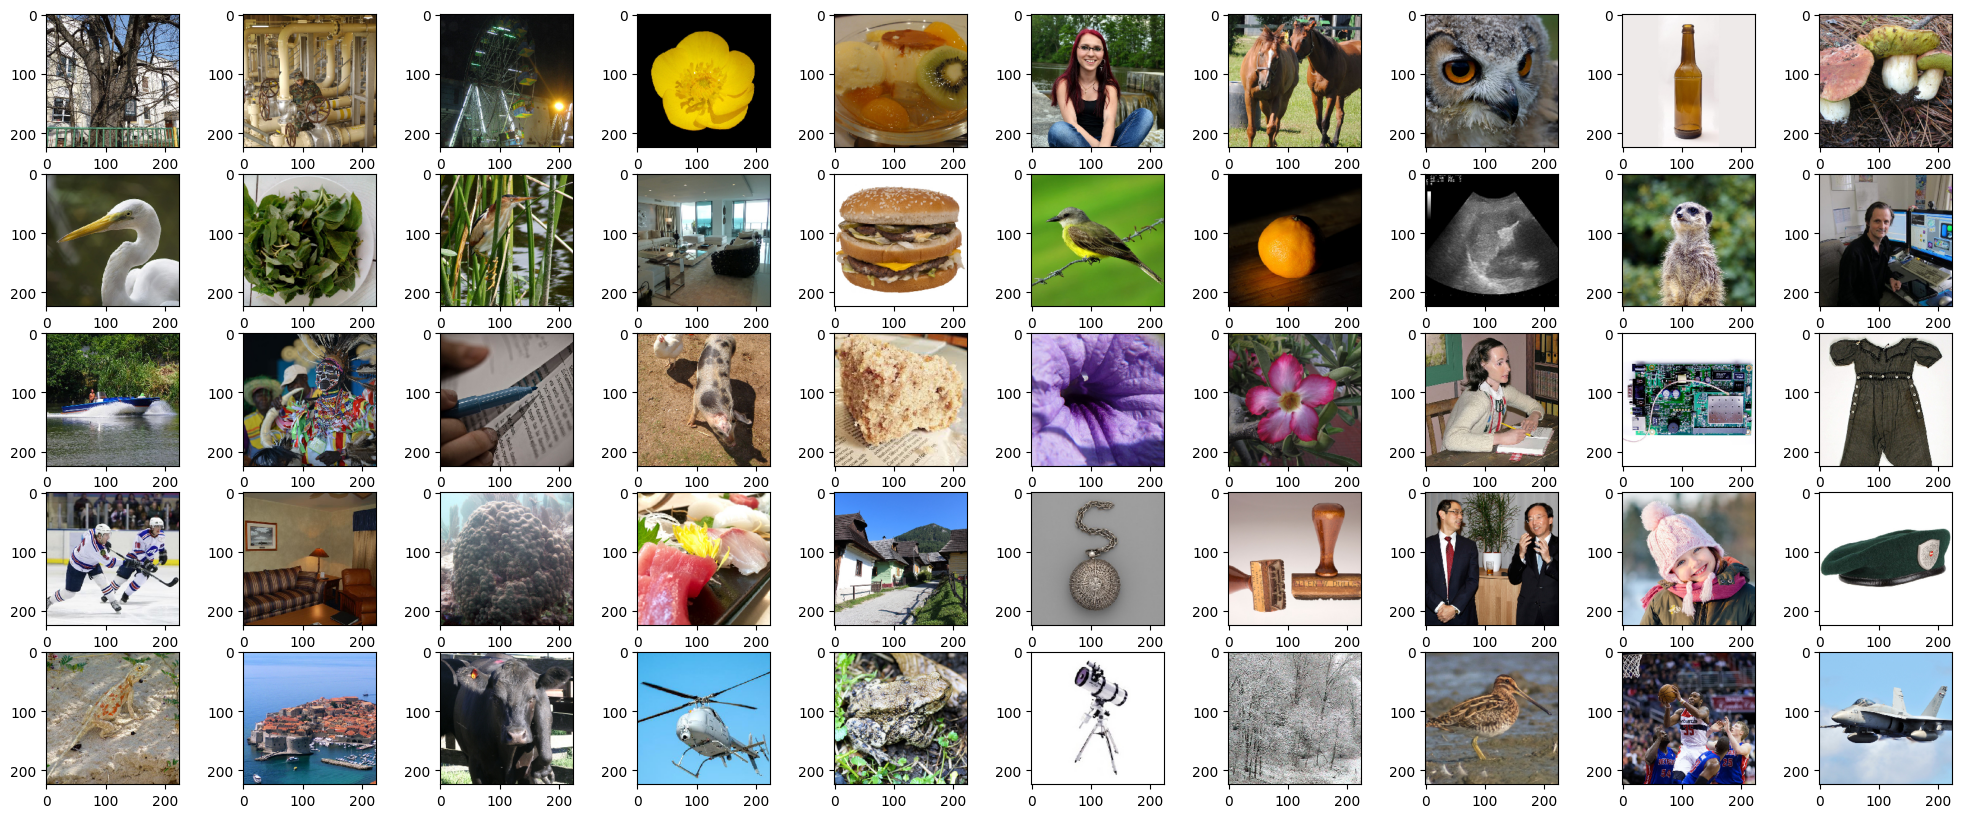

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(25, 10))
for i, imgs in enumerate(imagenet_50):
    row = i // 5
    col = i % 5
    ax[col, row].imshow(imgs.astype("int"))

In [ ]:
from IPython.display import clear_output


# for performance reason use as background only 10 images in PyTorch format
transform = transforms.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
)
background = transform(
    torch.tensor(imagenet_50[0:10]).permute(0, 3, 1, 2).to(device) / 255
)

# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html
explainer = shap.DeepExplainer(model.to(device), background)
shap_values = explainer.shap_values(img_t)  # List
clear_output()

По умолчанию возвращаются shap индексы для каждого класса, для каждого пикселя

In [ ]:
print("Classes", len(shap_values))
print("Values", shap_values[0].shape)

Classes 1000
Values (1, 3, 224, 224)


Для отображения результатов используем метод [shap.image_plot](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.image_plot.html?highlight=image_plot).

Его API ждет данные в виде списков numpy-массивов, поэтому нам потребуется преобразовать данные.


In [ ]:
img = get_image("cat_and_dog1.jpg")
# Get indexes of top5 classes predicted by model
top5_indexes = probs5.indices.squeeze(0).numpy().astype("int")

# Get shap values for this classes
shap_values_for_top_results = np.array(shap_values)[top5_indexes]

shap_list_numpy = []  # list of np.array

for v in shap_values_for_top_results:
    # because image_plot accept data in form(#samples x width x height x channels)
    # move cannel to last dimension [10, 1, 28, 28] -> (10,  28, 28, 1)
    shap_list_numpy.append(np.moveaxis(v, (1), (3)))

# Prepare test image
test_image = get_crop_img(img_t).reshape((1, 224, 224, 3))

# Get labels for top5 classes

shap_labels = np.array(idx2label)[top5_indexes]
shap_labels = [list(shap_labels)]  # One list for sample

print(
    "Len of shap_values list", len(shap_values_for_top_results)
)  # number of classes to explain
print("Shape of one value", shap_values_for_top_results[0].shape)  # n_samples, H,W,C
print(shap_labels)  # n_samples, number of classes

Len of shap_values list 5
Shape of one value (1, 3, 224, 224)
[['German_shepherd', 'tabby', 'tiger_cat', 'Egyptian_cat', 'space_heater']]


Теперь визуализируем результаты:

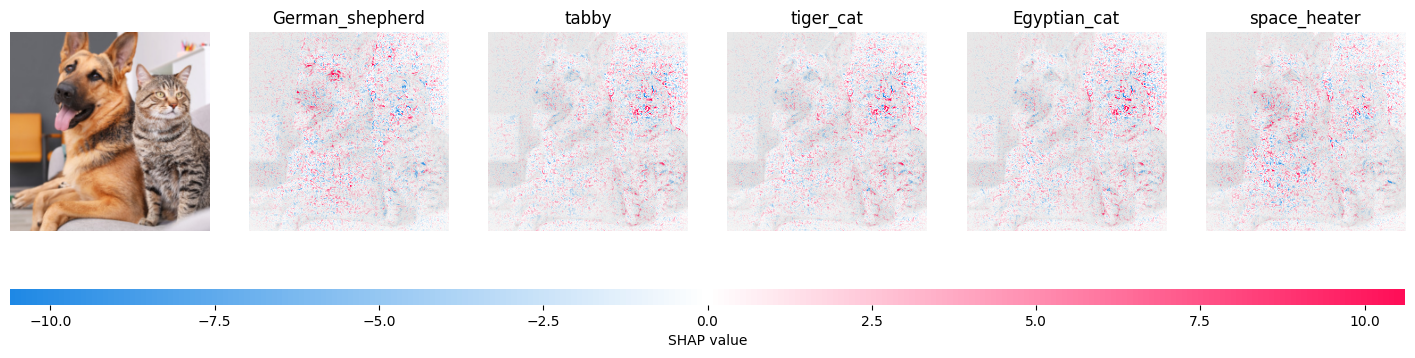

In [ ]:
shap.image_plot(shap_list_numpy, test_image, labels=shap_labels)

На практике чаще всего интересны объяснения только для нескольких классов с максимальной уверенностью.

И в документации описан параметр, который позволяет возвращать объяснения только для этих классов.

[[doc] shap.DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)

`ranked_outputs = 5, output_rank_order ='max'`

При этом возвращается кортеж:
shap_values и индексы классов, для которых получено объяснение.



In [ ]:
shape_values_for_best_pred, indexes = explainer.shap_values(
    img_t, ranked_outputs=5, output_rank_order="max"
)  # List

Результаты снова надо преобразовать из PyTorch формата:

In [ ]:
shap_list_numpy = []  # list of np.array

for v in shape_values_for_best_pred:
    # because image_plot accept data in form(#samples x width x height x channels)
    # move cannel to last dimension [10, 1, 28, 28] -> (10,  28, 28, 1)
    shap_list_numpy.append(np.moveaxis(v, (1), (3)))

Визуализируем результат:

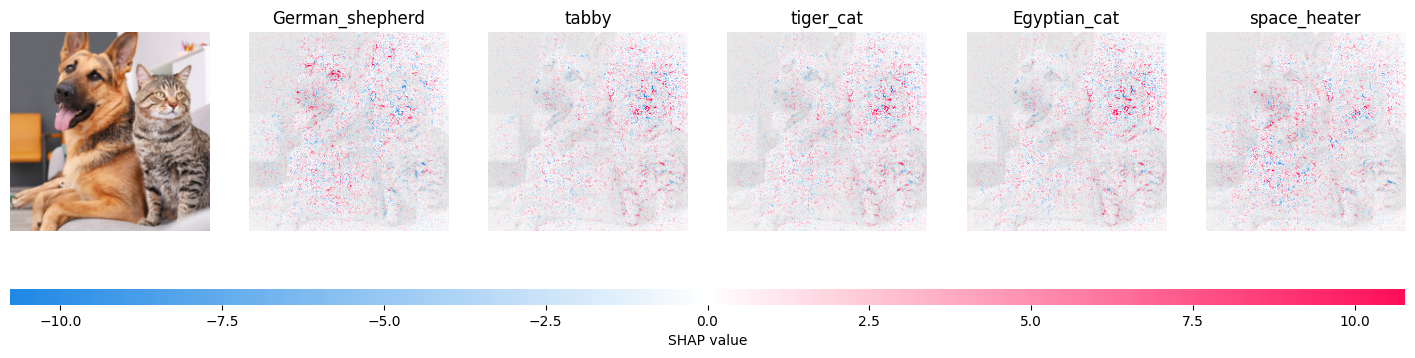

In [ ]:
shap.image_plot(shap_list_numpy, test_image, labels=shap_labels)